In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scvelo as scv
import FRED
if torch.__version__[:4] == '1.14': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
scv.set_figure_params('scvelo')  # for beautified visualization
%load_ext autoreload
%autoreload 2

Using device cpu


# 05c Single Cell Dataset Benchmarker
> Run FRED on a specified single cell dataset

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
notebook = "05c Single Cell Dataset Benchmarker"
dataset_name = "pancreas"
sigma = 'automatic'
flow_strength = 5
smoothness_weight = 0
flow_neighbor_loss_weight = 1
contrastive_flow_loss_weight = 20
diffdist_weight = 1
num_neighbors = 10

In [ ]:
# Parameters
notebook = "05c Single Cell Dataset Benchmarker.ipynb"
dataset_name = "dentategyrus"
sigma = "automatic"
flow_strength = 20
smoothness_weight = 0
flow_neighbor_loss_weight = 10
contrastive_flow_loss_weight = 10
diffdist_weight = 1
num_neighbors = 20
output_label = "run58_dataset_name-dentategyrus_sigma-automatic_flow_strength-20_smoothness_weight-0_flow_neighbor_loss_weight-10_contrastive_flow_loss_weight-10_diffdist_weight-1_num_neighbors-20"


# Set Up

In [ ]:
# Load single cell dataset from scvelo and get associated information
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch, rnavelo, rnavelo_pcs
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
import scvelo as scv
import os
from pathlib import Path

# choose correct dataset
Xpath = f"data/{dataset_name}/processed/X.txt"
if os.path.exists(Xpath):
    X = np.loadtxt(Xpath)
    flow = np.loadtxt(f"data/{dataset_name}/processed/flow.txt")
    labels = np.loadtxt(f"data/{dataset_name}/processed/labels.txt")
    latent_time = np.loadtxt(f"data/{dataset_name}/processed/latent_time.txt")
else:
    if dataset_name == "bone marrow":
        adata = scv.datasets.bonemarrow()
    elif dataset_name == "dentategyrus":
        adata = scv.datasets.dentategyrus()
    elif dataset_name == "pancreas":
        adata = scv.datasets.pancreas()
    elif dataset_name == "dentategyrus_lamanno":
        adata = scv.datasets.dentategyrus_lamanno()
    print("processing data with pcs")
    X, flow, labels, n_pcs = rnavelo_pcs(adata)
    # dynamical recovery
    scv.tl.recover_dynamics(adata, n_jobs=1)
    scv.tl.latent_time(adata)
    latent_time = adata.obs['latent_time'].to_numpy()
    # save the processed data to np txt files for ready loading in the future
    Path(f"data/{dataset_name}/processed").mkdir(parents = True,exist_ok=True)
    np.savetxt(f"data/{dataset_name}/processed/X.txt",X)
    np.savetxt(f"data/{dataset_name}/processed/flow.txt",flow)
    np.savetxt(f"data/{dataset_name}/processed/labels.txt",labels)
    np.savetxt(f"data/{dataset_name}/processed/latent_time.txt",latent_time)


Set sigma =  4.142324


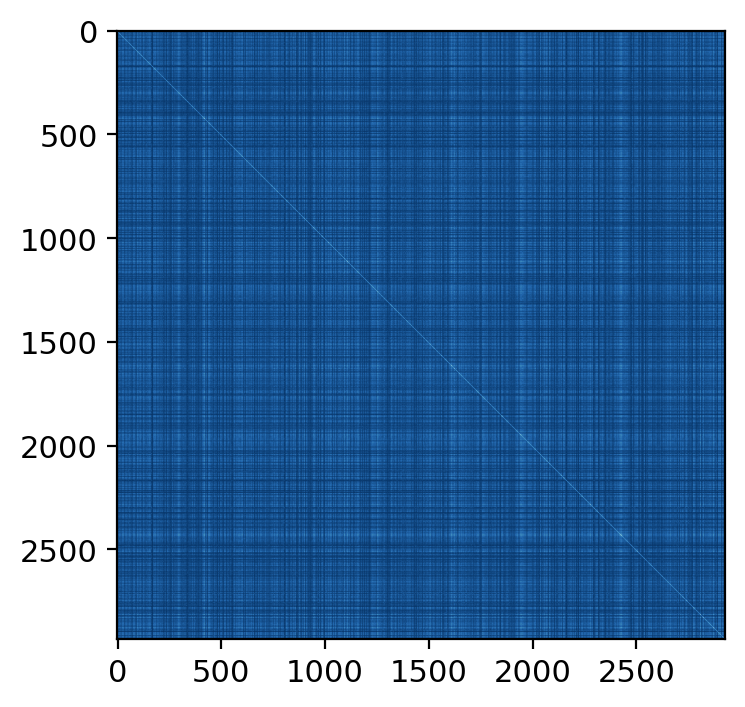

In [ ]:
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, dmap_coords_to_use=10, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

In [ ]:
X.shape

(2930, 30)

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = notebook.replace('.ipynb','')
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[X.shape[1], 20, 10, 5, 2],
            device=device,
            sigma=5,
            flow_strength=1,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "diffusion map regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
            "contrastive flow loss": contrastive_flow_loss_weight,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:23<03:32, 23.66s/it]

 20%|██        | 2/10 [00:47<03:09, 23.68s/it]

 30%|███       | 3/10 [01:11<02:45, 23.69s/it]

 40%|████      | 4/10 [01:34<02:22, 23.72s/it]

 50%|█████     | 5/10 [01:58<01:58, 23.73s/it]

 60%|██████    | 6/10 [02:22<01:35, 23.78s/it]

 70%|███████   | 7/10 [02:46<01:11, 23.77s/it]

 80%|████████  | 8/10 [03:10<00:47, 23.78s/it]

 90%|█████████ | 9/10 [03:33<00:23, 23.78s/it]

100%|██████████| 10/10 [03:56<00:00, 23.57s/it]

100%|██████████| 10/10 [03:56<00:00, 23.69s/it]

# Results

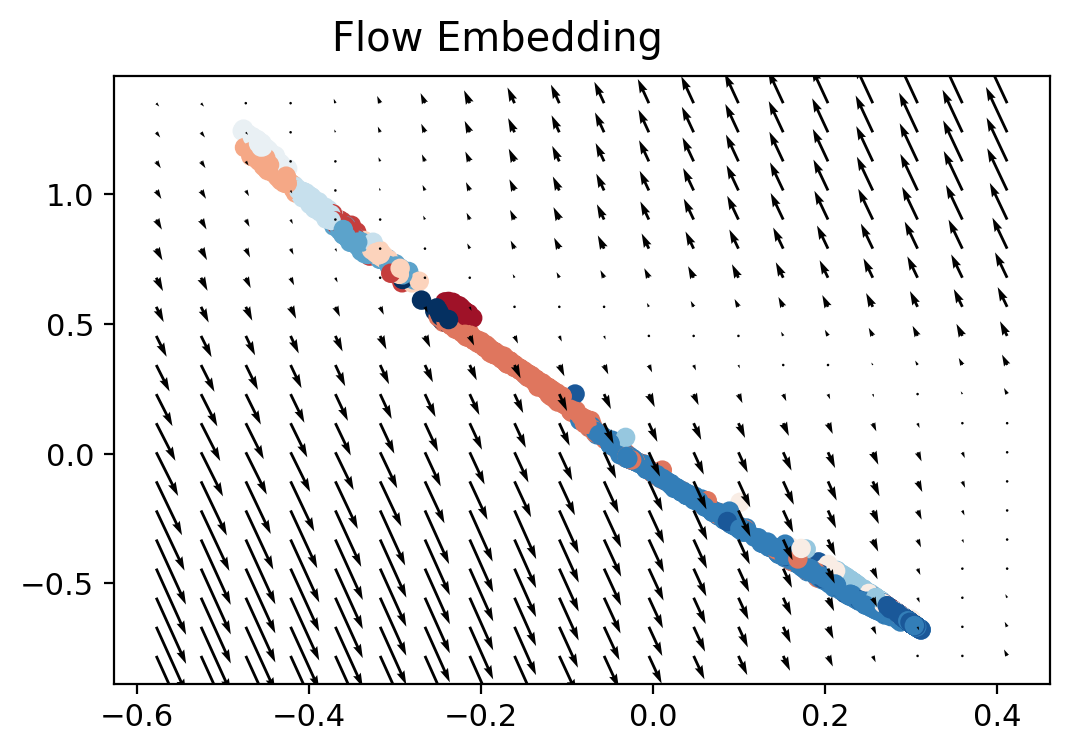

In [ ]:
FREDtrainer.visualize_embedding()

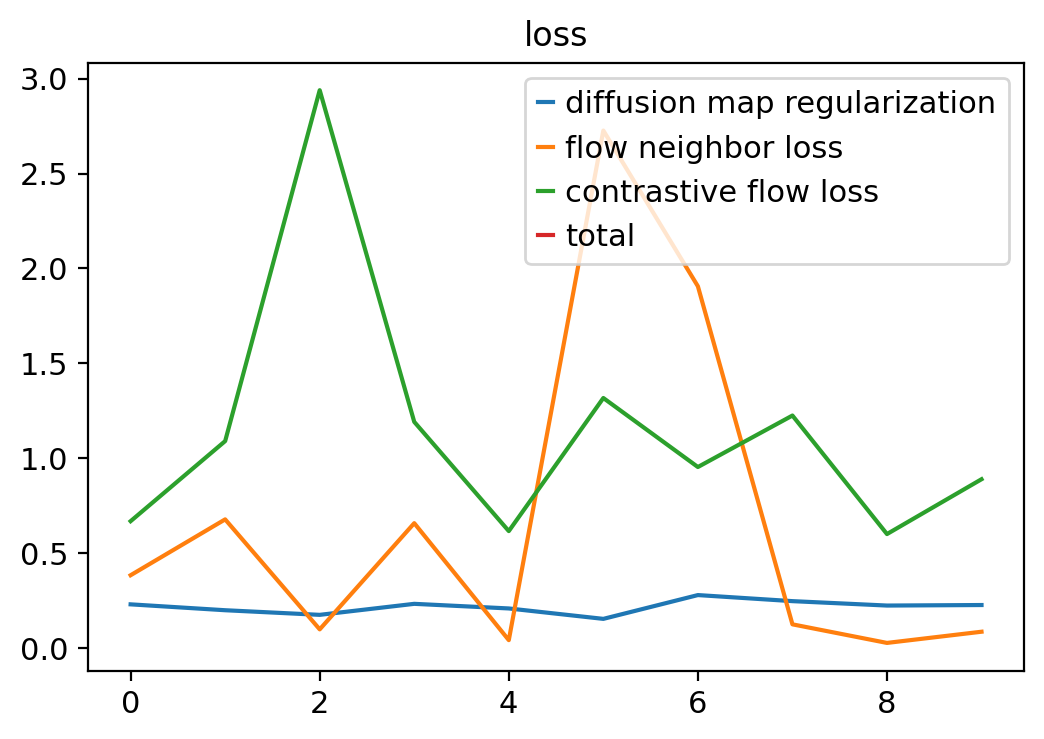

In [ ]:
FREDtrainer.visualize_loss()

In [ ]:
FREDtrainer.training_gif(duration=150)

HTML(value='<img src="data:image/gif;base64,R0lGODlhhANYAocAAP///////f//+///9v7///z///v///3//P3/9vn///b///j/+f…

# Qualitative analyses

We combine the embedded points with their velocities in the embedding space. 

In [ ]:
embedded_points = FREDtrainer.embedded_points.cpu().detach().numpy()
embedded_velocities = FREDtrainer.embedded_velocities.cpu().detach().numpy()

In [ ]:
# create unique identifier for notebook
import secrets
import string
alphabet = string.ascii_letters + string.digits
unid = ''.join(secrets.choice(alphabet) for i in range(20))  # for a 20-character password
spread_name = notebook + "_dataset_" + dataset_name
unid

'CcIIDLexxWYb7VrYtths'

In [ ]:
from FRED.metrics import comprehensive_flow_metrics
silhouette_score, silhouete_score_with_flow, knn_score, neighbor_score, monotone_score = comprehensive_flow_metrics(
    X = X,
    flows = flow,
    labels = labels,
    embedded_points = embedded_points,
    embedded_velocities = embedded_velocities,
    time_labels = latent_time,
    spreadsheet_name=spread_name,
    unid = unid,
)

Set sigma =  4.142324064380001


  0%|          | 0/1000 [00:00<?, ?it/s]

## SCORES ## 
 silhouette score w/o flows: 0.05329715833067894.
 silhouette score w/ flows:  0.05446536839008331 
 kNN Classifier 0.7476732161323681 
 Flow Neighbor Score 22132.572265625 
 Monotone Increasing Score -282.0112681333978


In [ ]:
import csv
with open(f"results/{spread_name}.csv", 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(
            [unid,
            sigma,
            flow_strength,
            flow_neighbor_loss_weight,
            contrastive_flow_loss_weight,
            num_neighbors,
            smoothness_weight,
            diffdist_weight,
            silhouette_score,
            silhouete_score_with_flow,
            knn_score,
            neighbor_score, 
            monotone_score,
            ])

# Save embeddings to txt files

In [ ]:
filename = f"{spread_name} - {dataset_name} - {unid}"
np.savetxt(f'embeddings/{filename} - X.txt',FREDtrainer.embedded_points.detach().cpu().numpy())
np.savetxt(f'embeddings/{filename} - V.txt',FREDtrainer.embedded_velocities.detach().cpu().numpy())